In [3]:
import sys
sys.path.append('/Users/akash/personal/finance/market-regime/')


import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.neighbors import NearestNeighbors
from models.autoencoder import Autoencoder
from models.contrastive_transformer import ContrastiveTransformer
from utils.config_loader import load_config
from models.storage import save_model, load_model
from torch.utils.tensorboard import SummaryWriter
import os
import modin as mpd
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import ks_2samp, entropy


In [88]:
import sys
import os

# Add the utils directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

import pandas as pd
import modin.pandas as mpd
from utils import clickhouse_data
import numpy as np
import talib
from sklearn.decomposition import PCA

# Define parameters
start_date = '2017-01-01'
end_date = '2025-12-31'

# Load and preprocess data
large_cap = clickhouse_data.clickhouse_largecap(start_date, end_date, size=3)
# mid_cap = clickhouse_data.clickhouse_midcap(start_date, end_date, size=1)
# small_cap = clickhouse_data.clickhouse_smallcap(start_date, end_date)

# # Fill missing dates
# large_cap = clickhouse_data.fill_missing_dates_modin_optimized(large_cap)
# mid_cap = clickhouse_data.fill_missing_dates_modin_optimized(mid_cap)
# small_cap = clickhouse_data.fill_missing_dates_modin_optimized(small_cap)

# Stack dataframes
all_cap = mpd.concat([large_cap])




    SELECT 
        financialinstrumentid,
        date,
        open,
        high,
        low,
        close,
        lastprice,
        previouscloseprice,
        volume,
        totaltradingvolume,
        totaltradevalue,
        totalnumberoftradesexecuted,
        tickersymbol,
        securityseries,
        settlementprice,
        financialinstrumentname
    FROM stock_data.tickers
    WHERE financialinstrumentid IN ('500002', '500034', '500049') AND date BETWEEN '2017-01-01' AND '2025-12-31'
    ORDER BY financialinstrumentid, date ASC
    


In [89]:
all_cap.head()


,financialinstrumentid,date,open,high,low,close,lastprice,previouscloseprice,volume,totaltradingvolume,totaltradevalue,totalnumberoftradesexecuted,tickersymbol,securityseries,settlementprice,financialinstrumentname
0,500002,2017-06-23,1500.35,1503.0,1430.20,1440.55,1440.55,1486.30,10963,10963,15950701,1256,,,0.0,ABB LTD.
1,500002,2017-06-27,1445.00,1457.0,1428.85,1442.95,1442.95,1440.55,9015,9015,13001118,1135,,,0.0,ABB LTD.
2,500002,2017-06-28,1443.00,1458.0,1425.80,1452.40,1452.40,1442.95,5662,5662,8171340,892,,,0.0,ABB LTD.
3,500002,2017-06-29,1458.00,1479.0,1435.00,1439.80,1439.80,1452.40,8416,8416,12287156,804,,,0.0,ABB LTD.
4,500002,2017-06-30,1419.25,1460.0,1411.25,1451.10,1451.10,1439.80,4764,4764,6900488,529,,,0.0,ABB LTD.


In [93]:
import numpy as np
import modin.pandas as pd
import talib
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
import modin.config as cfg

# Set Modin to use Ray
cfg.Engine.put("ray")

# Define functions for creating various types of bars
def create_volatility_bars(df, window=20, threshold=0.02):
    """Creates bars when rolling volatility exceeds a threshold."""
    df = df.copy()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['volatility'] = df['log_return'].rolling(window).std()
    return df[df['volatility'] >= threshold].reset_index(drop=True)

def create_cumulative_return_bars(df, return_threshold=0.02):
    df = df.copy()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['cum_return'] = df['log_return'].cumsum()
    mask = df['cum_return'].diff().abs() >= return_threshold
    return df.loc[mask].reset_index(drop=True)

def create_volume_bars(df, volume_threshold):
    df = df.copy()
    df['cum_volume'] = df['volume'].cumsum()
    mask = df['cum_volume'].diff() >= volume_threshold
    return df.loc[mask].reset_index(drop=True)

def create_dollar_bars(df, threshold):
    df = df.copy()
    df['dollar_volume'] = df['close'] * df['volume']
    df['cum_dollar_volume'] = df['dollar_volume'].cumsum()
    mask = df['cum_dollar_volume'].diff() >= threshold
    return df.loc[mask].reset_index(drop=True)

def create_tick_bars(df, tick_threshold):
    df = df.copy()
    df['tick_count'] = np.arange(1, len(df) + 1)
    df['cum_ticks'] = df['tick_count'].cumsum()
    mask = df['cum_ticks'].diff() >= tick_threshold
    return df.loc[mask].reset_index(drop=True)

# Function to extract features from the DataFrame
def extract_all_features(df, bar_type='time', bar_threshold=100000):
    df = df.copy()
    raw_cols = [
        'date', 'open', 'high', 'low', 'close', 'lastprice', 'previouscloseprice',
        'volume', 'totaltradingvolume', 'totaltradevalue', 'totalnumberoftradesexecuted'
    ]
    df = df[raw_cols]  # Ensure we only work with the relevant columns

    # Select bar type
    # if bar_type == 'cumulative_return':
    #     df = create_cumulative_return_bars(df, bar_threshold)
    # elif bar_type == 'volatility':
    #     df = create_volatility_bars(df, threshold=bar_threshold)
    # elif bar_type == 'tick':
    #     df = create_tick_bars(df, bar_threshold)
    # elif bar_type == 'volume':
    #     df = create_volume_bars(df, bar_threshold)
    # elif bar_type == 'dollar':
    #     df = create_dollar_bars(df, bar_threshold)

    # Ensure proper datetime format
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Convert to NumPy arrays for TA-Lib
    high_np = df['high'].to_numpy(dtype=np.float64)
    low_np = df['low'].to_numpy(dtype=np.float64)
    close_np = df['close'].to_numpy(dtype=np.float64)
    volume_np = df['volume'].to_numpy(dtype=np.float64)

    # Compute derived features
    df['prev_close_return'] = np.log(df['close'] / df['previouscloseprice']).replace([np.inf, -np.inf], 0)
    df['trading_intensity'] = (df['totalnumberoftradesexecuted'] / df['totaltradingvolume']).replace([np.inf, -np.inf], 0)
    df['turnover_ratio'] = (df['totaltradevalue'] / df['totaltradingvolume']).replace([np.inf, -np.inf], 0)
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']

    # Advanced technical indicators using TA-Lib
    df['cci_20'] = talib.CCI(high_np, low_np, close_np, timeperiod=20).astype(np.float32)
    df['williams_r'] = talib.WILLR(high_np, low_np, close_np, timeperiod=14).astype(np.float32)
    df['stoch_k'], df['stoch_d'] = talib.STOCH(
        high_np, low_np, close_np,
        fastk_period=14, slowk_period=3, slowd_period=3
    )
    df['chande_momentum'] = talib.CMO(close_np, timeperiod=14).astype(np.float32)
    df['obv'] = talib.OBV(close_np, volume_np).astype(np.float32)

    # Prophet seasonality extraction
    # === Prophet Seasonality Extraction ===
    df_prophet = df[['close']].reset_index()
    df_prophet.columns = ['ds', 'y']

    df_prophet = df_prophet._to_pandas()  # Convert Modin DataFrame to Pandas for Prophet

    prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet.fit(df_prophet)

    forecast = prophet.predict(df_prophet)

    # Assign Prophet features
    df['seasonal_weekly'] = forecast['weekly'].values[:len(df)] if 'weekly' in forecast.columns else 0
    df['seasonal_yearly'] = forecast['yearly'].values[:len(df)] if 'yearly' in forecast.columns else 0


    # Fill missing values
    df = df.ffill().fillna(0)

    return df

# === Feature Extraction & Normalization ===
# featured_df = extract_all_features(all_cap, bar_type="volatility", bar_threshold=100000)

instrument_feature_dict = {}

# Group by ticker symbol and apply feature extraction
for ticker, group_df in all_cap.groupby('tickersymbol'):
    print(f"Processing {ticker}")

    # Call your original feature extraction function per ticker
    features_df = extract_all_features(group_df, bar_type='volatility', bar_threshold=100000)

    # Store the results in a dictionary
    instrument_feature_dict[ticker] = features_df

# Combine all extracted features into one DataFrame with ticker-level indexing
featured_df = pd.concat(instrument_feature_dict.values(), keys=instrument_feature_dict.keys())



# Optimize Normalization
scaler = StandardScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(featured_df),
    columns=featured_df.columns,
    index=featured_df.index
)


Processing 


01:47:33 - cmdstanpy - INFO - Chain [1] start processing
01:47:33 - cmdstanpy - INFO - Chain [1] done processing
01:47:34 - cmdstanpy - INFO - Chain [1] start processing


Processing ABB


01:47:34 - cmdstanpy - INFO - Chain [1] done processing
01:47:34 - cmdstanpy - INFO - Chain [1] start processing
01:47:34 - cmdstanpy - INFO - Chain [1] done processing


Processing BAJFINANC


Processing BAJFINANCE


01:47:34 - cmdstanpy - INFO - Chain [1] start processing
01:47:34 - cmdstanpy - INFO - Chain [1] done processing
01:47:34 - cmdstanpy - INFO - Chain [1] start processing


Processing BEL


01:47:35 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Convert Pandas DataFrame to Numpy
scaled_df = np.array(scaled_df)  # Ensure it's a numpy array

# Define sequence length (7-day windows)
seq_len = 7
num_features = scaled_df.shape[1]

# Convert to rolling sequences for LSTM input
X_sequences = []
for i in range(len(scaled_df) - seq_len + 1):
    X_sequences.append(scaled_df[i : i + seq_len])

X_sequences = np.array(X_sequences)  # Shape: (num_samples, seq_len, num_features)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_sequences, dtype=torch.float32)


In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TemporalBlock(nn.Module):
    """TCN Block with dilated convolutions."""
    def __init__(self, input_dim, hidden_dim, kernel_size=3, dilation=1):
        super(TemporalBlock, self).__init__()
        self.conv = nn.Conv1d(input_dim, hidden_dim, kernel_size,
                              padding=(kernel_size - 1) * dilation,
                              dilation=dilation)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        return self.relu(x)

class HybridTCNTransformerVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=10, num_heads=4, num_layers=2):
        super(HybridTCNTransformerVAE, self).__init__()
        
        # === TCN Encoder ===
        self.tcn1 = TemporalBlock(input_dim, hidden_dim // 2, kernel_size=3, dilation=1)
        self.tcn2 = TemporalBlock(hidden_dim // 2, hidden_dim, kernel_size=3, dilation=2)
        
        # === Transformer Encoder ===
        transformer_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # === VAE Bottleneck ===
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # === Decoder ===
        self.fc_decoder = nn.Linear(latent_dim, hidden_dim)
        self.tcn_decoder1 = TemporalBlock(hidden_dim, hidden_dim // 2, kernel_size=3, dilation=2)
        self.tcn_decoder2 = TemporalBlock(hidden_dim // 2, input_dim, kernel_size=3, dilation=1)
        
        # === Contrastive Projection ===
        self.projection_head = nn.Linear(latent_dim, latent_dim)
    
    def reparameterize(self, mu, logvar):
        """VAE Reparameterization Trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def contrastive_loss(self, z_i, z_j):
        """Contrastive loss for representation learning."""
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        similarity = torch.mm(z_i, z_j.T)  # Cosine similarity
        loss = -torch.mean(torch.diag(similarity))  # Negative similarity as loss
        return loss
    
    def forward(self, x, x_pos=None, x_neg=None):
        # === TCN Encoding ===
        x = x.permute(0, 2, 1)  # (batch, features, sequence)
        x = self.tcn1(x)
        x = self.tcn2(x)
        x = x.permute(2, 0, 1)  # (sequence, batch, features)
        
        # === Transformer Encoding ===
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Global aggregation
        
        # === VAE Latent Representation ===
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        # === Contrastive Projection ===
        z_proj = self.projection_head(z)
        contrastive_loss = 0
        if x_pos is not None and x_neg is not None:
            _, z_pos, _ = self.forward(x_pos)
            _, z_neg, _ = self.forward(x_neg)
            contrastive_loss = self.contrastive_loss(z_proj, z_pos) + self.contrastive_loss(z_proj, z_neg)
        
        # === Decoder ===
        x_reconstructed = self.fc_decoder(z)
        x_reconstructed = x_reconstructed.unsqueeze(2)  # Prepare for TCN
        x_reconstructed = self.tcn_decoder1(x_reconstructed)
        x_reconstructed = self.tcn_decoder2(x_reconstructed)
        x_reconstructed = x_reconstructed.permute(0, 2, 1)  # (batch, seq, features)
        
        return x_reconstructed, z, contrastive_loss


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

# Set Device to Apple M2 GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

# After training completes
# print(f"Best Loss achieved: {best_loss:.6f}")

# # Directly access hyperparameters from your best_model instance
# print("Best Model Hyperparameters:")
# print(f"Hidden Dim: {best_model.tcn1.conv.in_channels}")  # initial input dim for TCN
# print(f"Latent Dim: {best_model.fc_mu.out_features}")
# print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")  # last optimizer LR used



# Best Loss achieved: 0.590967
# Best Model Hyperparameters:
# Hidden Dim: 25
# Latent Dim: 50
# Learning Rate: 0.0005

input_dim = num_features
hidden_dim = 256
latent_dim = 50
lr = 0.0005
epochs = 20
batch_size = 128
alpha = 1.0  # Weight for contrastive loss




# Initialize Model and Move to GPU
model = HybridTCNTransformerVAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_reconstruction = nn.MSELoss()

# DataLoader
train_loader = DataLoader(TensorDataset(X_tensor.to(device)), batch_size=batch_size, shuffle=True)

# === Training Loop with GPU Acceleration ===
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device)  # Move batch to GPU
        optimizer.zero_grad()

        # Forward Pass - Encode Latent Features
        with torch.no_grad():
            _, latent_features, _ = model(x_batch)

        # Compute Pairwise Cosine Similarities
        cosine_sim = torch.mm(latent_features, latent_features.T)

        # Find Closest Positive Pairs (Highest Similarity but not itself)
        x_positive = torch.stack([x_batch[cosine_sim[i].topk(2)[1][1]] for i in range(len(x_batch))])

        # Select Random Negative Pairs (Dissimilar samples)
        x_negative = x_batch[torch.randperm(len(x_batch))]

        # Forward Pass with Contrastive Learning
        reconstructed_x, latent_features, contrastive_loss = model(x_batch, x_positive, x_negative)

        # Compute Losses
        reconstruction_loss = criterion_reconstruction(reconstructed_x, x_batch)
        contrastive_loss = torch.clamp(contrastive_loss, min=0.0)  # Avoid negatives
        total_loss = reconstruction_loss + alpha * contrastive_loss

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")


Using device: mps


Epoch 1/20, Loss: 1.094692
Epoch 2/20, Loss: 0.741413
Epoch 3/20, Loss: 0.690703
Epoch 4/20, Loss: 0.652971
Epoch 5/20, Loss: 0.636830
Epoch 6/20, Loss: 0.675740
Epoch 7/20, Loss: 0.622287
Epoch 8/20, Loss: 0.620029
Epoch 9/20, Loss: 0.606853
Epoch 10/20, Loss: 0.598532
Epoch 11/20, Loss: 0.633255
Epoch 12/20, Loss: 0.623933
Epoch 13/20, Loss: 0.584477
Epoch 14/20, Loss: 0.576870
Epoch 15/20, Loss: 0.613809
Epoch 16/20, Loss: 0.571633
Epoch 17/20, Loss: 0.563827
Epoch 18/20, Loss: 0.601972
Epoch 19/20, Loss: 0.566642
Epoch 20/20, Loss: 0.560691


In [96]:
# Ensure tensor is on the correct device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
X_tensor = X_tensor.to(device)

# Run inference in no-grad mode
with torch.no_grad():
    output = model(X_tensor, X_tensor, X_tensor)  # Run model
    print(type(output), len(output))  # Debugging step

    _, extracted_features, _ = output  # Unpack correctly

# Move to CPU and convert to NumPy
extracted_features = extracted_features.cpu().numpy()
print(f"Extracted Features Shape: {extracted_features.shape}")  # Ensure proper shape


<class 'tuple'> 3
Extracted Features Shape: (1832, 50)


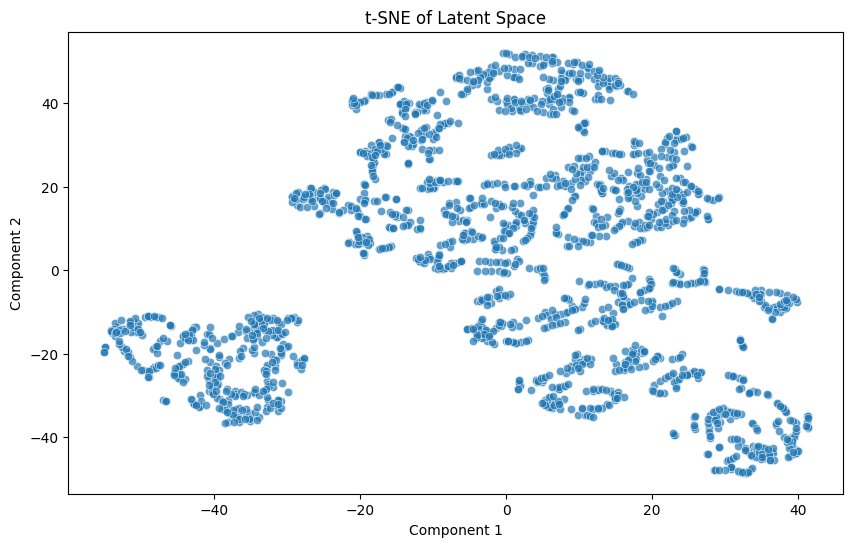

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, data_loader, method='tsne'):
    """
    Visualizes the latent space of the trained ContrastiveDenoisingLSTMAutoencoder
    using PCA or t-SNE.

    Parameters:
    - model: Trained autoencoder
    - data_loader: DataLoader containing the input data
    - method: 'pca' or 'tsne' for visualization
    """

    model.eval()  # Set model to evaluation mode
    latent_vectors = []
    
    with torch.no_grad():
        for batch in data_loader:
            x_batch = batch[0]
            _, latent_features, _ = model(x_batch, x_batch, x_batch)
            latent_vectors.append(latent_features)

    # Convert list to numpy array
    latent_vectors = torch.cat(latent_vectors).cpu().numpy()

    # Dimensionality Reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        title = "PCA of Latent Space"
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
        title = "t-SNE of Latent Space"
    
    latent_2d = reducer.fit_transform(latent_vectors)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], alpha=0.7)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Example Usage:
visualize_latent_space(model, train_loader, method='tsne')  # or method='pca'


In [98]:
X = extracted_features
# === Fit GMM ===
n_regimes = 3  # Change this if needed
gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
regime_labels = gmm.fit_predict(extracted_features)
featured_df = featured_df.copy().iloc[seq_len - 1:]
featured_df['gmm_regime'] = regime_labels

# === Fit HMM ===
hmm = GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=100, random_state=42)
hmm.fit(X)
featured_df['hmm_regime'] = hmm.predict(X)

# === Calculate Returns ===
featured_df['log_return'] = np.log(featured_df['close'] / featured_df['close'].shift(1))

# === High-Order Statistics & Summary ===
import numpy as np

def regime_summary(df, regime_col):
    summary = df.groupby(regime_col)['log_return'].agg(
        mean='mean',
        std='std',
        skew='skew',
        kurtosis=pd.Series.kurt  # ✅ FIXED: Use `pd.Series.kurt`
    )

    # Handle division by zero safely
    summary['sharpe'] = np.where(summary['std'] > 0, summary['mean'] / summary['std'], np.nan)

    # Fill NaNs (if any)
    summary.fillna(0, inplace=True)

    return summary

# === Regime Summary ===# === Statistical Evaluation ===
def evaluate_clustering(df, regime_col):
    regimes = df[regime_col].unique()
    
    # Silhouette Score
    silhouette = silhouette_score(X, df[regime_col])
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(X, df[regime_col])
    
    # Kolmogorov-Smirnov Test (compare distributions across regimes)
    ks_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                ks_stat, ks_pval = ks_2samp(
                    df[df[regime_col] == i]['log_return'].dropna(),
                    df[df[regime_col] == j]['log_return'].dropna()
                )
                ks_results[f'{i}-{j}'] = {'ks_stat': ks_stat, 'p_value': ks_pval}
    
    # Kullback-Leibler Divergence (compare probability distributions)
    kl_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                p = np.histogram(df[df[regime_col] == i]['log_return'].dropna(), bins=50, density=True)[0]
                q = np.histogram(df[df[regime_col] == j]['log_return'].dropna(), bins=50, density=True)[0]
                p += 1e-10  # Avoid division by zero
                q += 1e-10
                kl_div = entropy(p, q)
                kl_results[f'{i}-{j}'] = kl_div
    
    return {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': db_index,
        'Kolmogorov-Smirnov': ks_results,
        'KL Divergence': kl_results
    }

# Evaluate GMM and HMM
gmm_eval = evaluate_clustering(featured_df, 'gmm_regime')
hmm_eval = evaluate_clustering(featured_df, 'hmm_regime')




ValueError: Length of values (1832) does not match length of index (5508)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_regime_analysis(df, regime_col, title):
    """Enhanced Regime Analysis Plot with Background Shading & Labels"""
    plt.figure(figsize=(14, 7))
    
    # Define color palette based on number of regimes
    unique_regimes = sorted(df[regime_col].unique())
    colors = sns.color_palette("husl", n_colors=len(unique_regimes))
    
    # Plot Close Price
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(df.index, df['close'], color='black', linewidth=1.5, label='Close Price', alpha=0.7)

    # Add Background Color for Different Regimes
    prev_regime = None
    for i in range(1, len(df)):
        curr_regime = df.iloc[i][regime_col]
        prev_regime = df.iloc[i-1][regime_col]
        
        if curr_regime != prev_regime:
            ax1.axvspan(df.index[i-1], df.index[i], color=colors[curr_regime], alpha=0.2)

    # Plot Cumulative Log Returns
    ax2 = ax1.twinx()
    for regime, color in zip(unique_regimes, colors):
        regime_data = df[df[regime_col] == regime]
        ax2.plot(regime_data.index, regime_data['log_return'].cumsum(), label=f'Regime {regime}', color=color, linewidth=1.2)

    # Labels & Legends
    ax1.set_ylabel('Close Price', fontsize=12, color='black')
    ax2.set_ylabel('Cumulative Log Return', fontsize=12, color='blue')
    ax1.set_xlabel('Date', fontsize=12)
    
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)
    
    plt.title(f'Regime Analysis: {title}', fontsize=14, fontweight='bold')
    plt.show()

# Plot GMM Regimes
plot_regime_analysis(featured_df, 'gmm_regime', 'GMM')

# Plot HMM Regimes
plot_regime_analysis(featured_df, 'hmm_regime', 'HMM')
